In [49]:
import requests
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
register_matplotlib_converters()
from datetime import datetime
from datetime import timedelta
from meteostat import Point, Hourly
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### Feature Engineering

In [ ]:
#lag values, business day, hour, weather

In [93]:
starts_ends_1299 = pd.read_csv("start_end_1299.csv")
starts_ends_1299['start_time_hour'] = pd.to_datetime(starts_ends_1299['start_time_hour'], format="%Y-%m-%d %H:%M:%S")
starts_ends_1299 = starts_ends_1299.set_index('start_time_hour') 
se1299 = starts_ends_1299[(starts_ends_1299.index.get_level_values(0) > '2022-01-01')]

In [94]:
se1299 = se1299.reset_index()

se1299['hour'] = se1299.start_time_hour.dt.hour
se1299['day'] = se1299.start_time_hour.dt.weekday
se1299['week_end'] = np.where(((se1299['day']==5) | (se1299['day']==6)), 1, 0)

In [95]:
def get_time_of_day(row):
    a = row["hour"]
    
    night = [22, 23, 0, 1]
    early_morn = [2, 3, 4, 5]
    morn = [6, 7, 8, 9]
    noon = [10, 11, 12, 13]
    afternoon = [14, 15, 16, 17]
    evening = [18, 19, 20, 21]
    
    if a in night:
        return 'night'
    elif a in early_morn:
        return 'early_morn'
    elif a in morn:
        return 'morn'
    elif a in noon:
        return 'noon'
    elif a in afternoon:
        return 'afternoon'
    else:
        return 'evening'
    
se1299['time_of_day'] = se1299.apply(get_time_of_day, axis=1) 

In [96]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
se1299['holiday'] = (se1299.start_time_hour.dt.date.isin(
    USFederalHolidayCalendar().holidays(start='2022-01-01',end='2022-07-01').date))*1

In [97]:
# other vars
se1435 = pd.read_csv("start_end_1435.csv")
se1319 = pd.read_csv("start_end_1319.csv")

se1435['start_time_hour'] = pd.to_datetime(se1435['start_time_hour'], format="%Y-%m-%d %H:%M:%S")
se1319['start_time_hour'] = pd.to_datetime(se1319['start_time_hour'], format="%Y-%m-%d %H:%M:%S")

se1435['bike_diff_1435'] = se1435['bike_diff_1435'].astype(int)
se1319['bike_diff_1319'] = se1319['bike_diff_1319'].astype(int)

se1299 = se1299.merge(se1435, how='left', on='start_time_hour')
se1299 = se1299.merge(se1319, how='left', on='start_time_hour')

In [98]:
#other vars lag values

se1299['bike_1435_l1'] = se1299['bike_diff_1435'].shift(1)
se1299['bike_1435_l2'] = se1299['bike_diff_1435'].shift(2)
se1299['bike_1435_l3'] = se1299['bike_diff_1435'].shift(3)
se1299['bike_1435_l4'] = se1299['bike_diff_1435'].shift(4)
se1299['bike_1435_l5'] = se1299['bike_diff_1435'].shift(5)

se1299['bike_1319_l1'] = se1299['bike_diff_1319'].shift(1)
se1299['bike_1319_l2'] = se1299['bike_diff_1319'].shift(2)
se1299['bike_1319_l3'] = se1299['bike_diff_1319'].shift(3)
se1299['bike_1319_l4'] = se1299['bike_diff_1319'].shift(4)
se1299['bike_1319_l5'] = se1299['bike_diff_1319'].shift(5)

#actual lag values

se1299['bike_lag_1'] = se1299['bike_diff'].shift(1)
se1299['bike_lag_2'] = se1299['bike_diff'].shift(2)
se1299['bike_lag_3'] = se1299['bike_diff'].shift(3)
se1299['bike_lag_4'] = se1299['bike_diff'].shift(4)
se1299['bike_lag_5'] = se1299['bike_diff'].shift(5)

In [99]:
categorical_cols = ['day', 'week_end', 'time_of_day', 'holiday'] 

se1299 = pd.get_dummies(se1299, columns = categorical_cols)

In [100]:
se1299.columns

Index(['start_time_hour', 'bike_diff', 'hour', 'bike_diff_1435',
       'bike_diff_1319', 'bike_1435_l1', 'bike_1435_l2', 'bike_1435_l3',
       'bike_1435_l4', 'bike_1435_l5', 'bike_1319_l1', 'bike_1319_l2',
       'bike_1319_l3', 'bike_1319_l4', 'bike_1319_l5', 'bike_lag_1',
       'bike_lag_2', 'bike_lag_3', 'bike_lag_4', 'bike_lag_5', 'day_0',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'week_end_0',
       'week_end_1', 'time_of_day_afternoon', 'time_of_day_early_morn',
       'time_of_day_evening', 'time_of_day_morn', 'time_of_day_night',
       'time_of_day_noon', 'holiday_0', 'holiday_1'],
      dtype='object')

In [101]:
se1299 = se1299.set_index(se1299.start_time_hour)

In [102]:
se1299.head(2)

,start_time_hour,bike_diff,hour,bike_diff_1435,bike_diff_1319,bike_1435_l1,bike_1435_l2,bike_1435_l3,bike_1435_l4,bike_1435_l5,...,week_end_0,week_end_1,time_of_day_afternoon,time_of_day_early_morn,time_of_day_evening,time_of_day_morn,time_of_day_night,time_of_day_noon,holiday_0,holiday_1
start_time_hour,,,,,,,,,,,,,,,,,,,,,
2022-01-01 01:00:00,2022-01-01 01:00:00,0,1,0,0,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,1,0,1,0
2022-01-01 02:00:00,2022-01-01 02:00:00,-1,2,0,2,0.0,NaN,NaN,NaN,NaN,...,0,1,0,1,0,0,0,0,1,0


### Modelling

#### Prepare Data

In [103]:
var_input_wknd = se1299.drop(columns=['start_time_hour','hour', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5','day_6'])
var_input_day = se1299.drop(columns=['start_time_hour','hour', 'week_end_0', 'week_end_1'])

#### RF (vars is day data)

In [104]:
train_data = var_input_day[5:-168]
test_data = var_input_day[-168:-1]

x_train = train_data.drop(columns=['bike_diff'])
y_train = train_data['bike_diff']

x_test = test_data.drop(columns=['bike_diff'])
y_test = test_data['bike_diff']

In [105]:
param_grid = {"n_estimators": [10, 25, 50, 100, 200], "max_depth": [None, 2, 5, 7, 9]}

grid = GridSearchCV(RandomForestRegressor(random_state=17), param_grid, cv=5)
grid.fit(x_train, y_train);

best_rf = grid.best_estimator_

print(grid.best_params_)

{'max_depth': 9, 'n_estimators': 100}


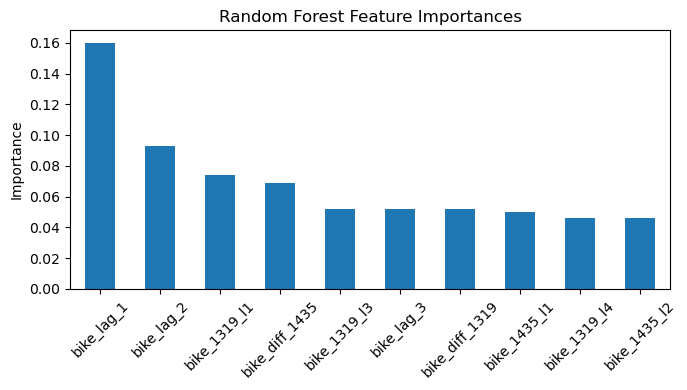

In [106]:
importances = best_rf.feature_importances_
forest_importances = pd.Series(importances, index=x_train.columns).nlargest(10)

fig, ax = plt.subplots(figsize=(7,4))
forest_importances.plot.bar(ax=ax, rot=45)
ax.set_title("Random Forest Feature Importances")
ax.set_ylabel("Importance")
fig.tight_layout()

In [108]:
predictions = grid.best_estimator_.predict(x_test)
predictions = pd.Series(predictions, index=x_test.index)

residuals = y_test - predictions
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.652095902967232


Text(0, 0.5, 'Inv. Change')

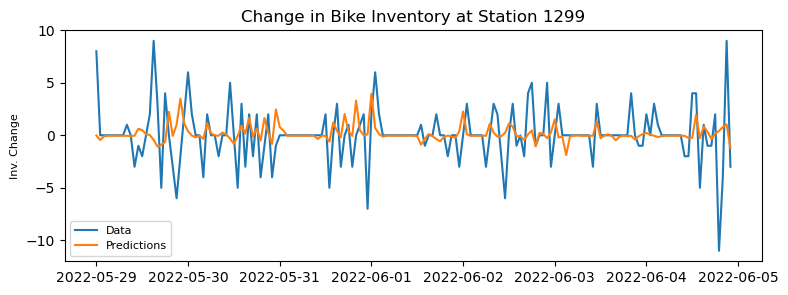

In [109]:
plt.figure(figsize=(9,3))

plt.plot(y_test)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=8)

plt.title('Change in Bike Inventory at Station 1299', fontsize=12)
plt.ylabel('Inv. Change', fontsize=8)

Text(0, 0.5, 'Error')

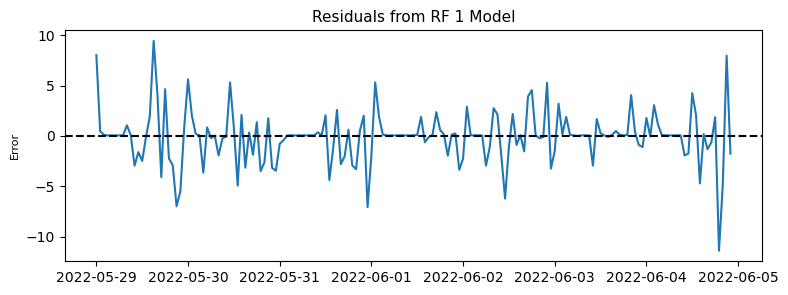

In [110]:
plt.figure(figsize=(9,3))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from RF 1 Model', fontsize=11)
plt.ylabel('Error', fontsize=8)

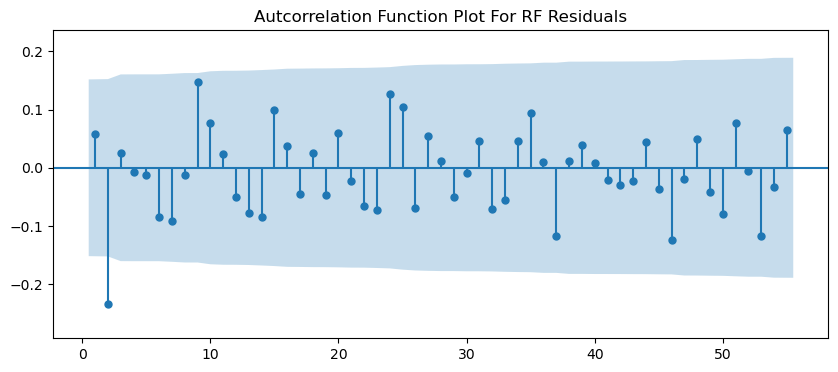

In [111]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(10, 4))
acf_plot = plot_acf(x = residuals, ax = ax, lags=55, auto_ylims=True, zero=False,
                    title = "Autcorrelation Function Plot For RF Residuals");

#### RF (using weekday vs not)

In [112]:
train_data = var_input_wknd[5:-168]
test_data = var_input_wknd[-168:-1]

x_train = train_data.drop(columns=['bike_diff'])
y_train = train_data['bike_diff']

x_test = test_data.drop(columns=['bike_diff'])
y_test = test_data['bike_diff']

In [113]:
param_grid = {"n_estimators": [10, 25, 50, 100, 200], "max_depth": [None, 2, 5, 7, 9]}

grid = GridSearchCV(RandomForestRegressor(random_state=17), param_grid, cv=5)
grid.fit(x_train, y_train);

best_rf = grid.best_estimator_

print(grid.best_params_)

{'max_depth': 9, 'n_estimators': 200}


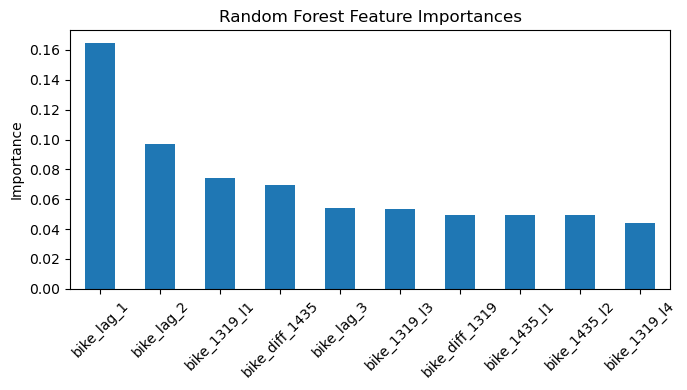

In [114]:
importances = best_rf.feature_importances_
forest_importances = pd.Series(importances, index=x_train.columns).nlargest(10)

fig, ax = plt.subplots(figsize=(7,4))
forest_importances.plot.bar(ax=ax, rot=45)
ax.set_title("Random Forest Feature Importances")
ax.set_ylabel("Importance")
fig.tight_layout()

In [116]:
predictions = grid.best_estimator_.predict(x_test)
predictions = pd.Series(predictions, index=x_test.index)

residuals = y_test - predictions
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.651363194506578


Text(0, 0.5, 'Inv. Change')

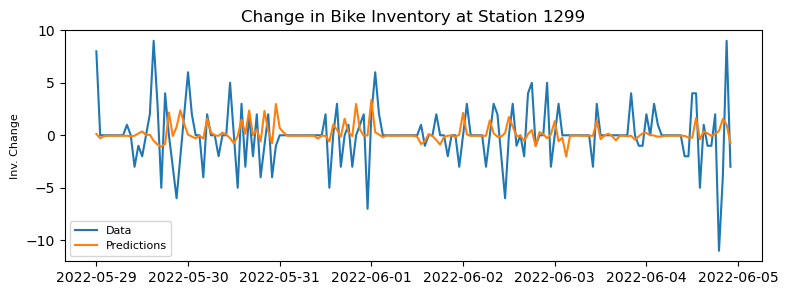

In [117]:
plt.figure(figsize=(9,3))

plt.plot(y_test)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=8)

plt.title('Change in Bike Inventory at Station 1299', fontsize=12)
plt.ylabel('Inv. Change', fontsize=8)

Text(0, 0.5, 'Error')

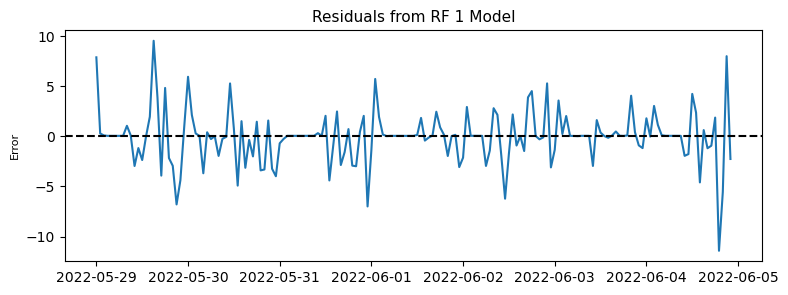

In [118]:
plt.figure(figsize=(9,3))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from RF 1 Model', fontsize=11)
plt.ylabel('Error', fontsize=8)

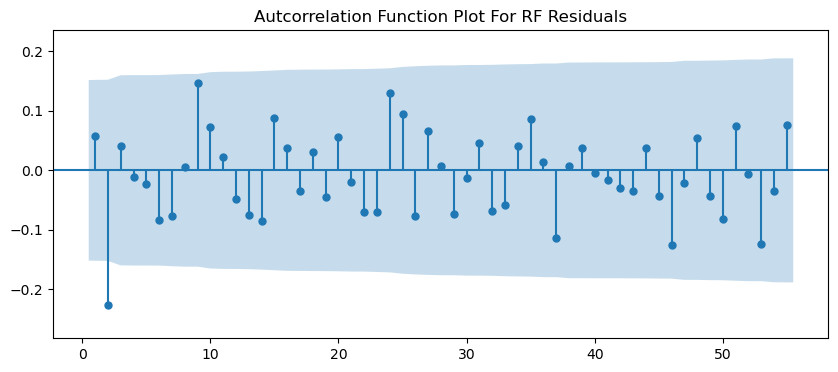

In [119]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(10, 4))
acf_plot = plot_acf(x = residuals, ax = ax, lags=55, auto_ylims=True, zero=False,
                    title = "Autcorrelation Function Plot For RF Residuals");